## Tarefas de regressão linear na base de dados do ENEM.

##### Alunos:
- Gabriel Fonseca (2111066)
- Yasmim Santos (2116925)
- Alejandro Elias (2111189)
- Pedro Lucas (2111131)

Base de dados escolhida - Exame Nacional do Ensino Médio (Enem): https://basedosdados.org/dataset/3e9c8804-c31c-4f48-9a45-d67f1c21a859

### Importando as dependências:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

### Lendo e visualizando os dados:

In [4]:
df_enem = pd.read_csv(
    f"../../data/out/enem-dados-tratados.csv",
    dtype={
        "id_inscricao": np.int64,
        "ensino": int,
        "nota_ciencias_natureza": float,
        "nota_ciencias_humanas": float,
        "nota_linguagens_codigos": float,
        "nota_matematica": float,
        "nota_redacao": float,
        "q_formacao_pai": str,
        "q_formacao_mae": str,
        "q_renda_familia": str,
    },
)

df_enem

,id_inscricao,ensino,nota_ciencias_natureza,nota_ciencias_humanas,nota_linguagens_codigos,nota_matematica,nota_redacao,q_formacao_pai,q_formacao_mae,q_renda_familia,ano
0,150001892848,3,366.8,436.9,374.2,331.4,380.0,B,A,C,2015
1,150002421428,1,512.0,636.9,552.0,549.2,760.0,A,A,C,2015
2,150004396764,1,470.8,519.3,465.2,350.8,580.0,B,A,B,2015
3,150001657786,1,492.6,641.2,553.2,649.5,840.0,A,A,A,2015
4,150005415838,1,473.3,533.4,443.3,447.4,400.0,A,A,A,2015
...,...,...,...,...,...,...,...,...,...,...,...
357268,210054596750,1,450.6,403.1,443.3,479.8,0.0,E,E,B,2022
357269,210056286560,1,416.5,427.3,484.6,376.2,0.0,D,D,A,2022
357270,210057495281,1,462.1,421.7,432.1,530.9,0.0,C,D,B,2022
357271,210056812211,1,519.1,570.4,537.3,388.7,0.0,D,H,B,2022


### Preparando os dados para utilização no modelo:

In [5]:
mm_scaler = MinMaxScaler()

df_enem = df_enem[df_enem["nota_ciencias_natureza"] != 0.0]
df_enem = df_enem[df_enem["nota_ciencias_humanas"] != 0.0]

df_enem["nota_ciencias_natureza_scl"] = mm_scaler.fit_transform(df_enem[["nota_ciencias_natureza"]])
df_enem["nota_ciencias_humanas_scl"] = mm_scaler.fit_transform(df_enem[["nota_ciencias_humanas"]])

df_enem

,id_inscricao,ensino,nota_ciencias_natureza,nota_ciencias_humanas,nota_linguagens_codigos,nota_matematica,nota_redacao,q_formacao_pai,q_formacao_mae,q_renda_familia,ano,nota_ciencias_natureza_scl,nota_ciencias_humanas_scl
0,150001892848,3,366.8,436.9,374.2,331.4,380.0,B,A,C,2015,0.111326,0.236413
1,150002421428,1,512.0,636.9,552.0,549.2,760.0,A,A,C,2015,0.367095,0.595157
2,150004396764,1,470.8,519.3,465.2,350.8,580.0,B,A,B,2015,0.294522,0.384215
3,150001657786,1,492.6,641.2,553.2,649.5,840.0,A,A,A,2015,0.332922,0.602870
4,150005415838,1,473.3,533.4,443.3,447.4,400.0,A,A,A,2015,0.298925,0.409507
...,...,...,...,...,...,...,...,...,...,...,...,...,...
357268,210054596750,1,450.6,403.1,443.3,479.8,0.0,E,E,B,2022,0.258940,0.175785
357269,210056286560,1,416.5,427.3,484.6,376.2,0.0,D,D,A,2022,0.198873,0.219193
357270,210057495281,1,462.1,421.7,432.1,530.9,0.0,C,D,B,2022,0.279197,0.209148
357271,210056812211,1,519.1,570.4,537.3,388.7,0.0,D,H,B,2022,0.379602,0.475874


In [6]:
features = [
    "nota_ciencias_natureza_scl",
]

X = np.array(df_enem[features])
Y = np.array(df_enem["nota_ciencias_humanas_scl"])

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, train_size=0.8, random_state=5487
)

X_train: np.ndarray = X_train
Y_train: np.ndarray = Y_train
X_test: np.ndarray = X_test
Y_test: np.ndarray = Y_test

pd.DataFrame(X_train).head()

,0
0,0.288180
1,0.258411
2,0.315484
3,0.112912
4,0.275145


### Realizando a regressão:

In [7]:
from sklearn.linear_model import LinearRegression as SelectedModel

model = SelectedModel()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
r2 = r2_score(Y_test, Y_pred)
score = model.score(X_test, Y_test)

coef_str = "".join([f"{c:.5f}" for c in model.coef_])

pd.DataFrame(
    {
        "Intercept": [f"{model.intercept_:.5f}"],
        "Coeficiente(s)": [coef_str],
        "R2": [f"{r2:.2%}"],
        "Score": [f"{score:.2%}"],
    }
)

,Intercept,Coeficiente(s),R2
0,0.09572,0.82515,49.32%


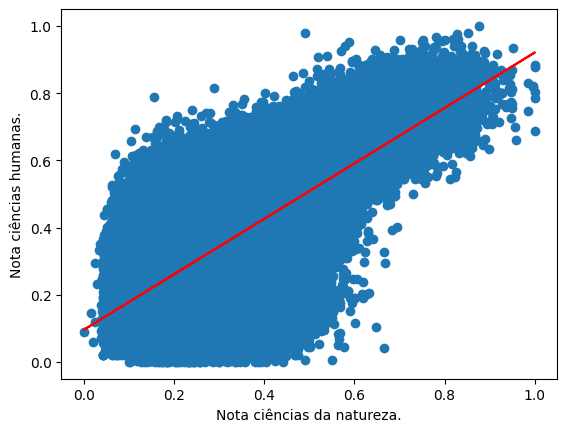

In [8]:
plt.xlabel("Nota ciências da natureza.")
plt.ylabel("Nota ciências humanas.")

plt.scatter(X, Y)
plt.plot(X_test, Y_pred, "r-")
plt.show()